In [1]:
import urllib.request
import os
import tarfile

In [2]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'

#下载
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('downloaded ' + str(result))
else:
    print('Data alreadly exists')
    
#解压
if not os.path.exists('data/cifar-10-batches-py'):
    tfile = tarfile.open('data/cifar-10-python.tar.gz','r:gz')
    result  = tfile.extractall('data/')
    print('Extrated to /data/cifar-10-batches-py/')
else:
    print("Directiry already exists")

In [3]:
import numpy as np
import os
import pickle as p

In [4]:
def load_CIFAR_batch(filename):
    with open(filename,'rb') as f:
        data_dict = p.load(f,encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        images = images.reshape(10000,3,32,32)
        images = images.transpose(0,2,3,1)
        
        labels = np.array(labels)
        return images,labels

In [5]:
def load_CIFAR_data(data_dir):
    images_train = []
    labels_train = []
    
    for i in range(5):
        f = os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading',str(f))
        
        image_batch,label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch,label_batch
        
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loading CIAF-10 data')
    
    return Xtrain,Ytrain,Xtest,Ytest

In [6]:
data_dir = 'data/cifar-10-batches-py'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loading CIAF-10 data


In [7]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

2


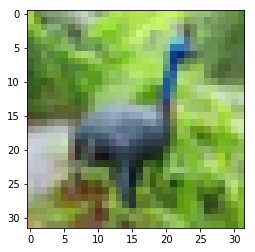

In [9]:
plt.imshow(Xtrain[6])
print(Ytrain[6])

In [10]:
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
              5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [11]:
def plot_images_labels_predictoion(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num > 10:
        num = 10    
    for i in range(num):
        ax = plt.subplot(2,5,1+i)
        ax.imshow(images[idx],cmap='binary')
        
        title = str(i) +","+label_dict[labels[idx]]
        
        if len(prediction) > 0:
            title += '=>' + label_dict[prediction[idx]]
            
        ax.set_title(title,fontsize = 10)
        idx+=1
        
    plt.show()

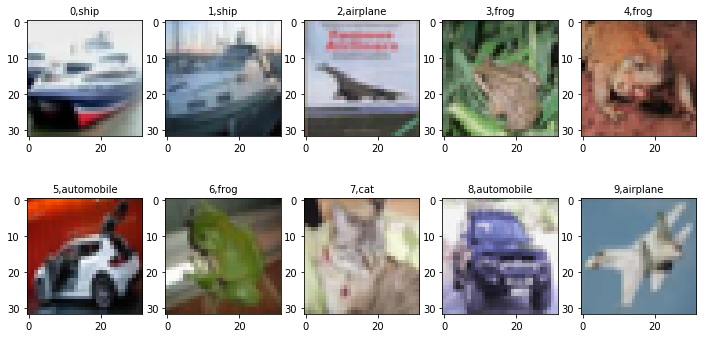

In [12]:
plot_images_labels_predictoion(Xtest,Ytest,[],1,10)

In [13]:
#数据预处理
print(Xtrain[0][0][0])

Xtrain_normalize = Xtrain.astype('float32') / 255.0
Xtest_normalize = Xtest.astype('float32') / 255.0

print(Xtrain_normalize[0][0][0])

[59 62 63]
[0.23137255 0.24313726 0.24705882]


In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse = False)

yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)

Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)

Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)

print(Ytrain.shape)
print(Ytrain_onehot.shape)

(50000,)
(50000, 10)


In [15]:
import tensorflow as tf

def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev = 0.1),name = 'W')

def bias(shape):
     return tf.Variable(tf.constant(0.1,shape = shape),name = 'b')
    
def conv2(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_2x2(x):
     return tf.nn.max_pool(x,ksize = [1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [16]:
# 输入层
#32x32图像 3通道
with tf.name_scope('input_layer'):
    x = tf.placeholder('float',shape=[None,32,32,3],name='X')

#第一个卷积层
#卷积核3x3，输入通道3，输出通道32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32])
    b1 = bias([32])
    conv_1 = conv2(x,W1)+b1
    conv_1 = tf.nn.relu(conv_1)
    
#第一个池化层
#降采样16x16,不该变输出通道
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)

    
#第二个卷积层
#卷积核3x3，输入通道32，输出通道64
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2 = conv2(pool_1,W2)+b2
    conv_2 = tf.nn.relu(conv_2)
    
#第二个池化层
#降采样8x8,不该变输出通道
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)
    
#全连接层8x8,x64 = 4096
#128个神经元
with tf.name_scope('fc'):
    W3 = weight([4096,128])
    b3 =  bias([128])
    flat = tf.reshape(pool_2,[-1,4096])
    h = tf.nn.softmax(tf.matmul(flat,W3)+b3)
    h_dropout = tf.nn.dropout(h,keep_prob = 0.8)
    
#输出层
#输出10个神经元
with tf.name_scope('output_layer'):
    W4 = weight([128,10])
    b4 =  bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout,W4)+b4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
#构建模型
with tf.name_scope("optimizer"):
    #定义占位符
    y = tf.placeholder( "float", shape=[None,10],name= "label")

    # 定义损失函数
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                                   (logits=pred,labels=y))

    #选择迭代器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
#定义准确率
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(pred, 1),
                                  tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [19]:
#启动会话
import os
from time import time
train_epochs =25
batch_size = 50 
total_batch = int(len(Xtrain)/batch_size)
epoch_list= []
accuracy_list=[]
loss_list=[]
epoch = tf.Variable(0,name= 'epoch',trainable= False)

In [20]:
startTime=time()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
#断点续训
#设置检查点存储目录
ckpt_dir = "CIFAR10_log/"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
#生成saver
saver = tf.train.Saver(max_to_keep=1)

#如果有检查点文件,读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess, ckpt)#加载所有的参数
    #从这里开始就可以直接使用模型进行预测，或者接着继续训练了else:
else:
    print("Training from scratch.")

#获取续训参数
start = sess.run(epoch)
print("Training starts form 0 epoch." .format(start+1))

Training from scratch.
Training starts form 0 epoch.


In [22]:
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number*batch_size:(number+ 1)*batch_size], \
              Ytrain_onehot[number*batch_size:(number+ 1)*batch_size]

In [30]:
#迭代训练
for ep in range(start, train_epochs):
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x: batch_x, y: batch_y})
        if i% 100==0:
            print("Step {}".format(i), "finished")
               
    loss,acc = sess.run([loss_function,accuracy],feed_dict={x: batch_x, y: batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)

    print("Train epoch:", '%02d' % (sess.run(epoch)+1), \
          "Loss=';(.6f)" .format(loss)," Accuracy=" ,acc)
                        
    saver.save(sess,ckpt_dir+ "CIFAR1O_cnn_model.cpkt",global_step=ep+1)
    sess.run(epoch.assign(ep+1))

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 01 Loss=';(.6f)  Accuracy= 0.08
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 02 Loss=';(.6f)  Accuracy= 0.12
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 03 Loss=';(.6f)  Accuracy= 0.18
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 04 Loss=';(.6f)  Accuracy= 0.14
Step 0 finished
Step 100

KeyboardInterrupt: 

In [31]:
duration = time() - startTime
print("Train finished takes:",duration)

Train finished takes: 601.9291348457336


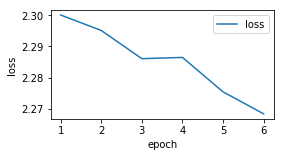

In [36]:
#可视化损失值
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label= "loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

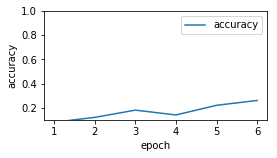

In [35]:
#可视化准确率
plt.plot(epoch_list, accuracy_list, label= "accuracy")
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [40]:
#计算测试集上的准确率
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch  = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict= {x:test_image_batch,y:test_label_batch})
    test_acc_sum += test_batch_acc
    
test_acc = float(test_acc_sum/test_total_batch)
print('Test accuracy:{:.6f}'.format(test_acc))

Test accuracy:0.252600


In [43]:
#利用模型进行预测
test_pred = sess.run(pred,feed_dict={x: Xtest_normalize[:10]})
prediction_result  = sess.run(tf.argmax(test_pred,1))

In [ ]:
#可视化预测结果
plot_images_lebels_prediction(Xtest,Ytest,prediction_result,0.10)